## STATS 507 Project: Amazon

Note: ChatGPT was used throughout this notebook to assist in cleaning code and making the functions. 

Load model: 

In [3]:
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
classifier("I love this!")

C:\Users\heley\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'anger', 'score': 0.004419791977852583},
  {'label': 'disgust', 'score': 0.001611992483958602},
  {'label': 'fear', 'score': 0.0004138525982853025},
  {'label': 'joy', 'score': 0.9771687984466553},
  {'label': 'neutral', 'score': 0.005764589179307222},
  {'label': 'sadness', 'score': 0.002092393347993493},
  {'label': 'surprise', 'score': 0.008528691716492176}]]

In [4]:
classifier

The classifier above takes in a phrase and outputs an anger, disgust, fear, joy, neutral, sadness, and suprise score.

### Data and Cleaning

Data and variables: \
This dataset contains a subset of Amazon customer reviews from the "Cell Phones & Accessories" category.
- reviererID: string
- asin: string
- reveiwerName: string
- helpful: 2 items (ints) helpful, total
- reviewText: string
- overall: int (out of 5)
- summary: string
- unixReviewTime: int
- reviewTime; string

Import packages:

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

In [351]:
file_path = 'amazon.json'

# Load the JSON file into a DataFrame
df = pd.read_json(file_path, lines = True)

# Display the DataFrame
print(df)


            reviewerID        asin       reviewerName helpful  \
0       A30TL5EWN6DFXT  120401325X          christina  [0, 0]   
1        ASY55RVNIL0UD  120401325X           emily l.  [0, 0]   
2       A2TMXE2AFO7ONB  120401325X              Erica  [0, 0]   
3        AWJ0WZQYMYFQ4  120401325X                 JM  [4, 4]   
4        ATX7CZYFXI1KW  120401325X   patrice m rogoza  [2, 3]   
...                ...         ...                ...     ...   
194434  A1YMNTFLNDYQ1F  B00LORXVUE    eyeused2loveher  [0, 0]   
194435  A15TX8B2L8B20S  B00LORXVUE       Jon Davidson  [0, 0]   
194436  A3JI7QRZO1QG8X  B00LORXVUE  Joyce M. Davidson  [0, 0]   
194437  A1NHB2VC68YQNM  B00LORXVUE     Nurse Farrugia  [0, 0]   
194438  A1AG6U022WHXBF  B00LORXVUE     Trisha Crocker  [0, 0]   

                                               reviewText  overall  \
0       They look good and stick good! I just don't li...        4   
1       These stickers work like the review says they ...        5   
2       T

For one iteration of the dataframe, I will group by 'asin' and add a helpfulness ratio/helpfulness percentage for each asin below:

In [353]:
# Extract helpful votes and total votes as separate columns
df[['helpful_votes', 'total_votes']] = pd.DataFrame(df['helpful'].tolist(), index=df.index)

# Calculate the helpfulness ratio
df['helpfulness_ratio'] = df['helpful_votes'] / df['total_votes']
df['helpfulness_ratio'] = df['helpfulness_ratio'].fillna(0)  # Replace NaN with 0 (e.g., when total_votes is 0)

# Group by 'asin' and aggregate
grouped = df.groupby("asin").agg({
    "summary": lambda x: " ".join(x),          # Combine all summaries for each product
    "overall": "mean",                        # Average overall rating
    "helpful_votes": "sum",                   # Total helpful votes
    "total_votes": "sum",                     # Total votes
    "helpfulness_ratio": "mean"               # Average helpfulness ratio
}).reset_index()

# Add a new column for the percentage of helpful reviews
grouped['helpful_percentage'] = (grouped['helpful_votes'] / grouped['total_votes']).fillna(0) * 100


In [355]:
grouped

,asin,summary,overall,helpful_votes,total_votes,helpfulness_ratio,helpful_percentage
0,120401325X,Looks Good Really great product. LOVE LOVE LOV...,4.428571,7,9,0.309524,77.777778
1,3998899561,not a good Idea Solid Case Perfect Case Just w...,4.600000,24,32,0.625000,75.000000
2,6073894996,Top Quality. Works like the Expensive Version ...,3.891892,8,12,0.083333,66.666667
3,7532385086,I recommend Nice Perfect! Pretty Not what I ex...,4.444444,3,3,0.111111,100.000000
4,7887421268,Loved it at first Cute Simple and Attractive P...,4.000000,2,2,0.076923,100.000000
...,...,...,...,...,...,...,...
10424,B00LH1QZR8,Cool idea that worked! Very cool phone case. c...,5.000000,0,0,0.000000,0.000000
10425,B00LH1R3C4,Feel Bulletproof One of a kind! leather in any...,5.000000,0,0,0.000000,0.000000
10426,B00LH1R5HW,Feel it Obsessed Never seen a case like this b...,5.000000,0,0,0.000000,0.000000
10427,B00LH1R6SK,Ssssssssuper Sssssatisfied. Feel the python! Y...,5.000000,0,0,0.000000,0.000000


Truncate 'summary' column to account for 512 unit cap on classifier: 

In [357]:
# Load tokenizer for the model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")

def truncate_review(text):
    tokens = tokenizer.encode(text, truncation=True, max_length=512, add_special_tokens=True)
    return tokenizer.decode(tokens, skip_special_tokens=True)

# Apply truncation
grouped['truncated_summary'] = grouped['summary'].apply(truncate_review)

Use classifier on grouped 'asin' 'summary' words: 

In [359]:
# Add sentiment scores to the grouped DataFrame
grouped["sentiment_score"] = grouped["truncated_summary"].apply(classifier)

In [361]:
grouped['sentiment_score']

0        [[{'label': 'anger', 'score': 0.00373571459203...
1        [[{'label': 'anger', 'score': 0.02106820978224...
2        [[{'label': 'anger', 'score': 0.01062374468892...
3        [[{'label': 'anger', 'score': 0.00315380003303...
4        [[{'label': 'anger', 'score': 0.00436992105096...
                               ...                        
10424    [[{'label': 'anger', 'score': 0.00205436581745...
10425    [[{'label': 'anger', 'score': 0.00540470611304...
10426    [[{'label': 'anger', 'score': 0.03033531084656...
10427    [[{'label': 'anger', 'score': 0.01020969264209...
10428    [[{'label': 'anger', 'score': 0.00704042427241...
Name: sentiment_score, Length: 10429, dtype: object

Unpack the list to give each emotion it's own score column: 

In [363]:
# Adjust the function to handle nested lists
def extract_emotion_scores(emotion_scores):
    try:
        # Unpack the nested structure: extract the inner list
        if isinstance(emotion_scores, list) and len(emotion_scores) > 0 and isinstance(emotion_scores[0], list):
            emotion_scores = emotion_scores[0]
        
        # Ensure it's a list of dictionaries
        return {item['label']: item['score'] for item in emotion_scores}
    except (TypeError, KeyError):
        print(f"Unexpected structure: {emotion_scores}")
        return {}  # Return an empty dictionary if the structure is invalid

# Apply the function and create the DataFrame
df_emotions = pd.DataFrame(grouped['sentiment_score'].apply(extract_emotion_scores).tolist())

# Concatenate the new DataFrame with the original grouped DataFrame
grouped = pd.concat([grouped, df_emotions], axis=1)

# Display the result
print(grouped.head())

         asin                                            summary   overall  \
0  120401325X  Looks Good Really great product. LOVE LOVE LOV...  4.428571   
1  3998899561  not a good Idea Solid Case Perfect Case Just w...  4.600000   
2  6073894996  Top Quality. Works like the Expensive Version ...  3.891892   
3  7532385086  I recommend Nice Perfect! Pretty Not what I ex...  4.444444   
4  7887421268  Loved it at first Cute Simple and Attractive P...  4.000000   

   helpful_votes  total_votes  helpfulness_ratio  helpful_percentage  \
0              7            9           0.309524           77.777778   
1             24           32           0.625000           75.000000   
2              8           12           0.083333           66.666667   
3              3            3           0.111111          100.000000   
4              2            2           0.076923          100.000000   

                                   truncated_summary  \
0  Looks Good Really great product. LOVE L

### Individual Product Summaries

We can do lots of summary/visualizations with this output, including looking at individual 'asin' emotional analysis. Below are two different 'bad' (less than 2.5 stars) rated products and their emotional scores.

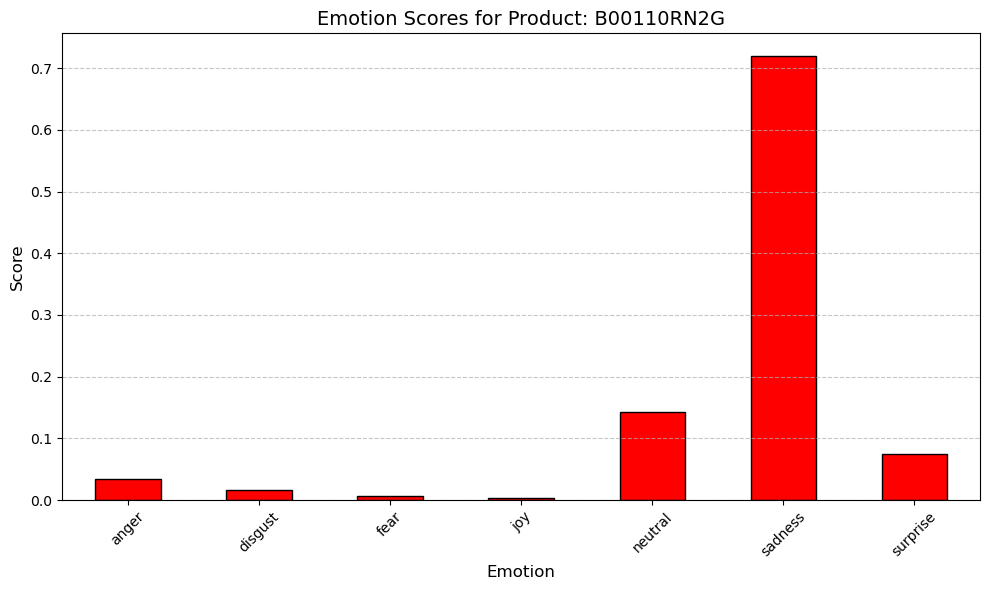

In [367]:
# Extract the 5th row (index 4 because Python uses zero-based indexing)
fifth_row = low_rated_products.iloc[4]

# Select emotion score columns (adjust the column names to match your DataFrame)
emotion_scores = fifth_row[['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']]

# Plot the emotion scores
plt.figure(figsize=(10, 6))
emotion_scores.plot(kind='bar', color='red', edgecolor='black')
plt.title(f"Emotion Scores for Product: {fifth_row['asin']}", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Emotion", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


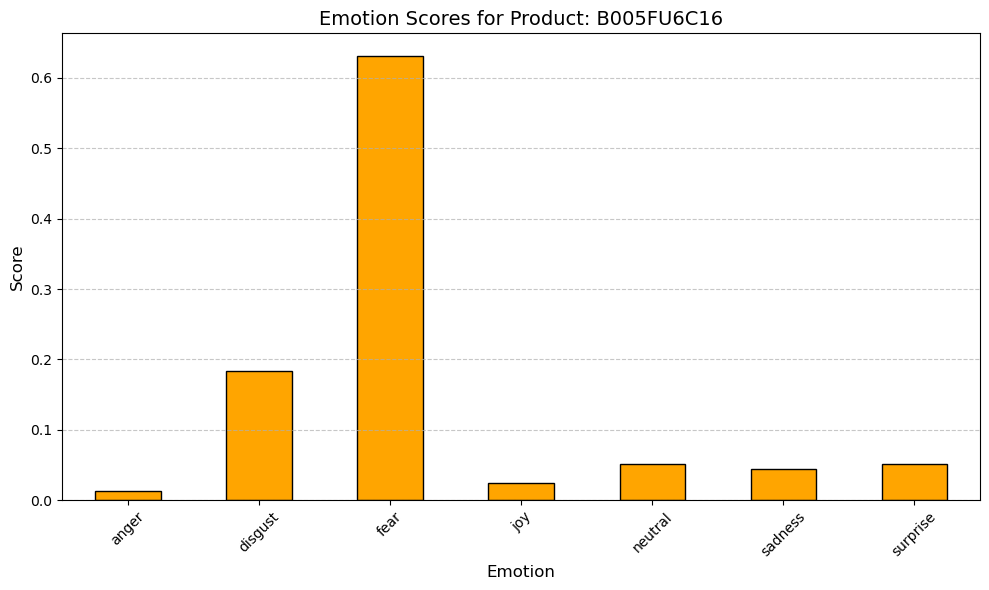

In [369]:
# Extract the 5th row (index 4 because Python uses zero-based indexing)
fearful_review = grouped.iloc[2989]

# Select emotion score columns (adjust the column names to match your DataFrame)
emotion_scores = fearful_review[['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']]

# Plot the emotion scores
plt.figure(figsize=(10, 6))
emotion_scores.plot(kind='bar', color='orange', edgecolor='black')
plt.title(f"Emotion Scores for Product: {fearful_review['asin']}", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Emotion", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



As we can see above, some bad scores showcase different emotions through their words. 

Let's create a new column 'group' that specifies 'good' and 'bad' reviews for each asin: 

In [373]:
# Separtate into good and bad reviews below
grouped['group'] = grouped['overall'].apply(lambda x: 'Good' if x > 2.5 else 'Bad')

In [375]:
grouped.head()

,asin,summary,overall,helpful_votes,total_votes,helpfulness_ratio,helpful_percentage,truncated_summary,sentiment_score,anger,disgust,fear,joy,neutral,sadness,surprise,group
0,120401325X,Looks Good Really great product. LOVE LOVE LOV...,4.428571,7,9,0.309524,77.777778,Looks Good Really great product. LOVE LOVE LOV...,"[[{'label': 'anger', 'score': 0.00373571459203...",0.003736,0.003922,0.000632,0.842561,0.107278,0.004221,0.037649,Good
1,3998899561,not a good Idea Solid Case Perfect Case Just w...,4.600000,24,32,0.625000,75.000000,not a good Idea Solid Case Perfect Case Just w...,"[[{'label': 'anger', 'score': 0.02106820978224...",0.021068,0.007315,0.007659,0.076930,0.152698,0.403238,0.331091,Good
2,6073894996,Top Quality. Works like the Expensive Version ...,3.891892,8,12,0.083333,66.666667,Top Quality. Works like the Expensive Version ...,"[[{'label': 'anger', 'score': 0.01062374468892...",0.010624,0.010403,0.633985,0.052663,0.100046,0.131202,0.061077,Good
3,7532385086,I recommend Nice Perfect! Pretty Not what I ex...,4.444444,3,3,0.111111,100.000000,I recommend Nice Perfect! Pretty Not what I ex...,"[[{'label': 'anger', 'score': 0.00315380003303...",0.003154,0.000928,0.001223,0.555836,0.057654,0.033179,0.348025,Good
4,7887421268,Loved it at first Cute Simple and Attractive P...,4.000000,2,2,0.076923,100.000000,Loved it at first Cute Simple and Attractive P...,"[[{'label': 'anger', 'score': 0.00436992105096...",0.004370,0.002417,0.000586,0.944912,0.028341,0.003131,0.016242,Good


### Summaires of Findings using Visualizaitions

In [33]:
# List of emotion columns
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

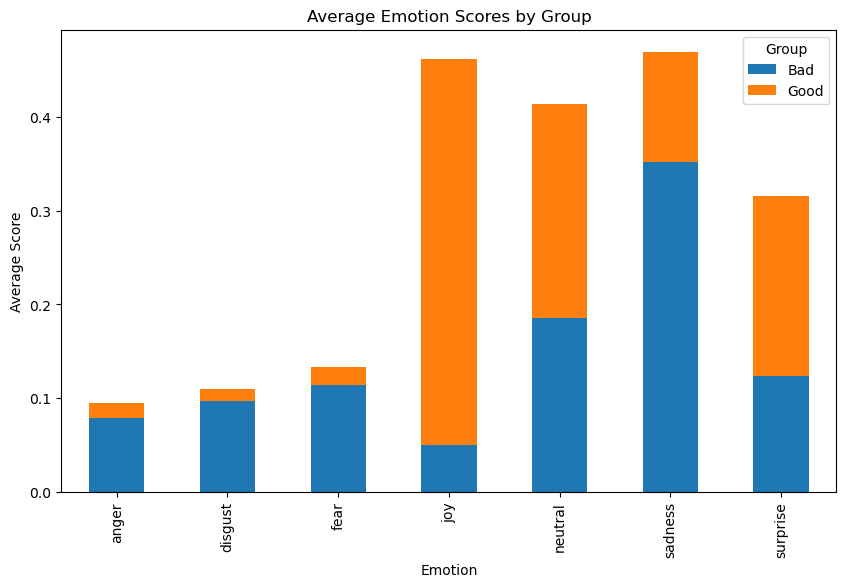

In [400]:
# Stacked Bar Chart
emotion_means = grouped.groupby('group')[emotion_columns].mean()
emotion_means.T.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Average Emotion Scores by Group')
plt.ylabel('Average Score')
plt.xlabel('Emotion')
plt.legend(title='Group')
plt.show()

In [377]:
grouped['group'].value_counts()

group
Good    10310
Bad       119
Name: count, dtype: int64

As we can see above, we see that joy is the leading emotion for good reviews while sadness leads bad reviews with anger, disgust, and fear following behind. Interestingly, suprise is more involved in good reviews than bad reviews. It is also good to note that there are significantly more good reviews than bad reviews in this grouped dataframe. Below are some more visualizations of this data: 

In [37]:
# Melt the DataFrame for easier plotting
df_melted = grouped.melt(id_vars=['group'], value_vars=emotion_columns, 
                    var_name='Emotion', value_name='Score')

In [41]:
df_melted.head()

,group,Emotion,Score
0,Good,anger,0.003736
1,Good,anger,0.021068
2,Good,anger,0.010624
3,Good,anger,0.003154
4,Good,anger,0.004370


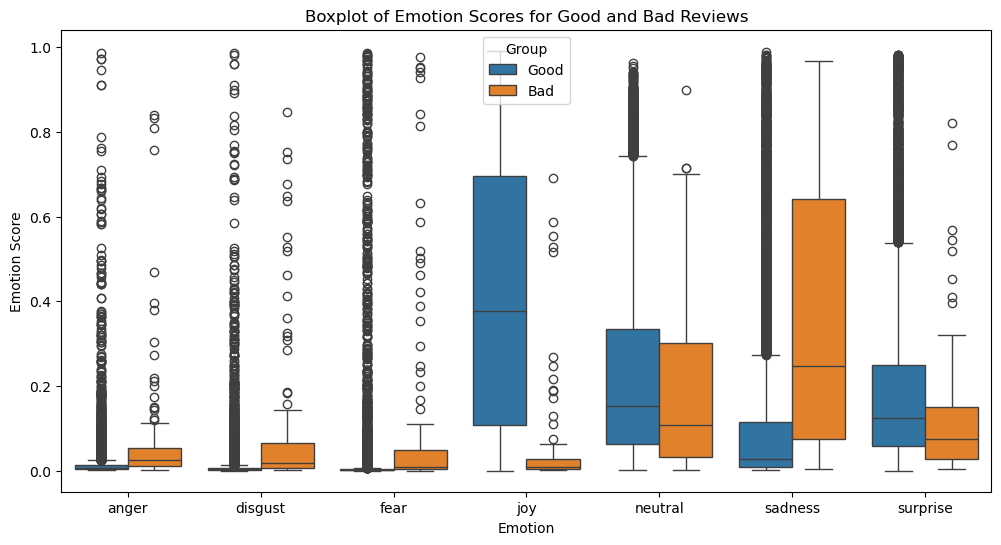

In [43]:
# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='Emotion', y='Score', hue='group')
plt.title('Boxplot of Emotion Scores for Good and Bad Reviews')
plt.ylabel('Emotion Score')
plt.xlabel('Emotion')
plt.legend(title='Group')
plt.show()

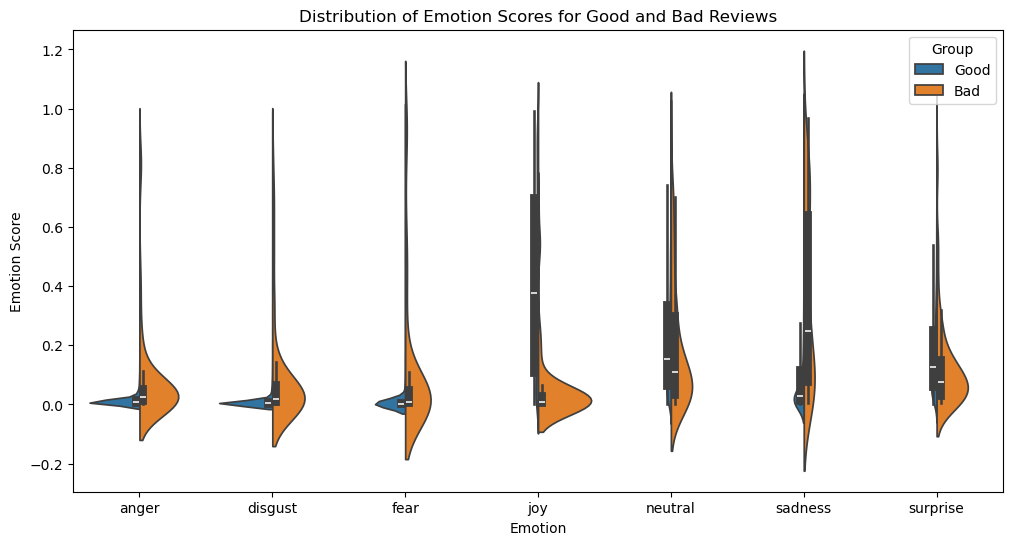

In [47]:
# Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_melted, x='Emotion', y='Score', hue='group', split=True)
plt.title('Distribution of Emotion Scores for Good and Bad Reviews')
plt.ylabel('Emotion Score')
plt.xlabel('Emotion')
plt.legend(title='Group')
plt.show()

### Looking into Helpful_Percentage for each product and emotion scores affect on Overall Rating

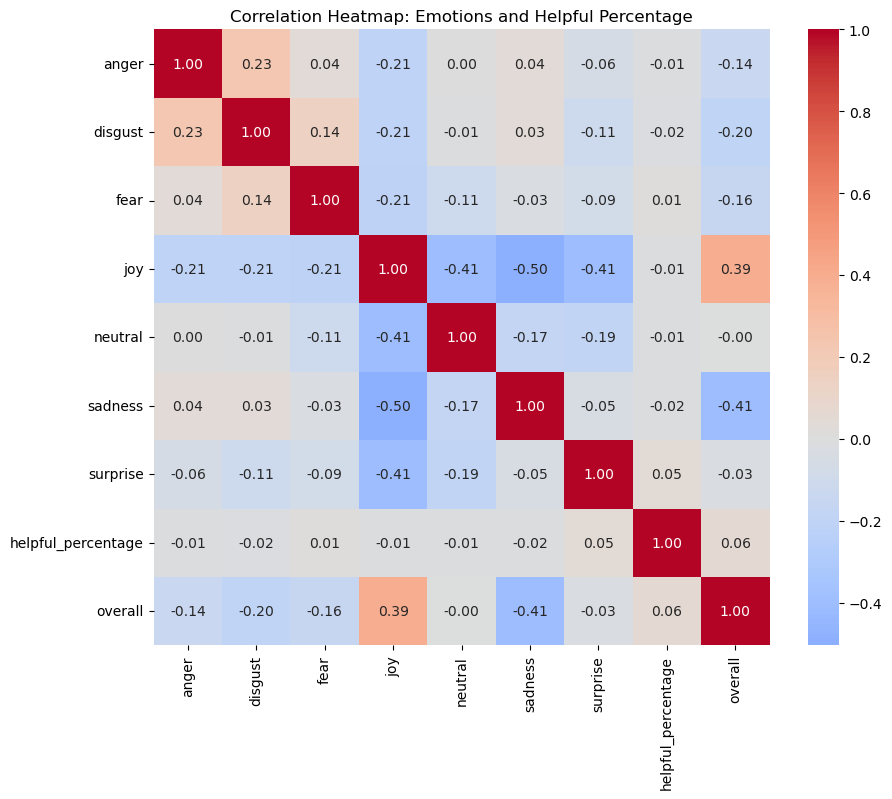

In [73]:
# Correlation matrix
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise', 'helpful_percentage', 'overall']
corr_matrix = grouped[emotion_columns].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', center = 0, square=True)
plt.title('Correlation Heatmap: Emotions and Helpful Percentage')
plt.show()

This above heatmap does not tell us much about correclation with helpful_percentage. However, it is interesting to see have each emotion score impacts each other and the overall ratings. 

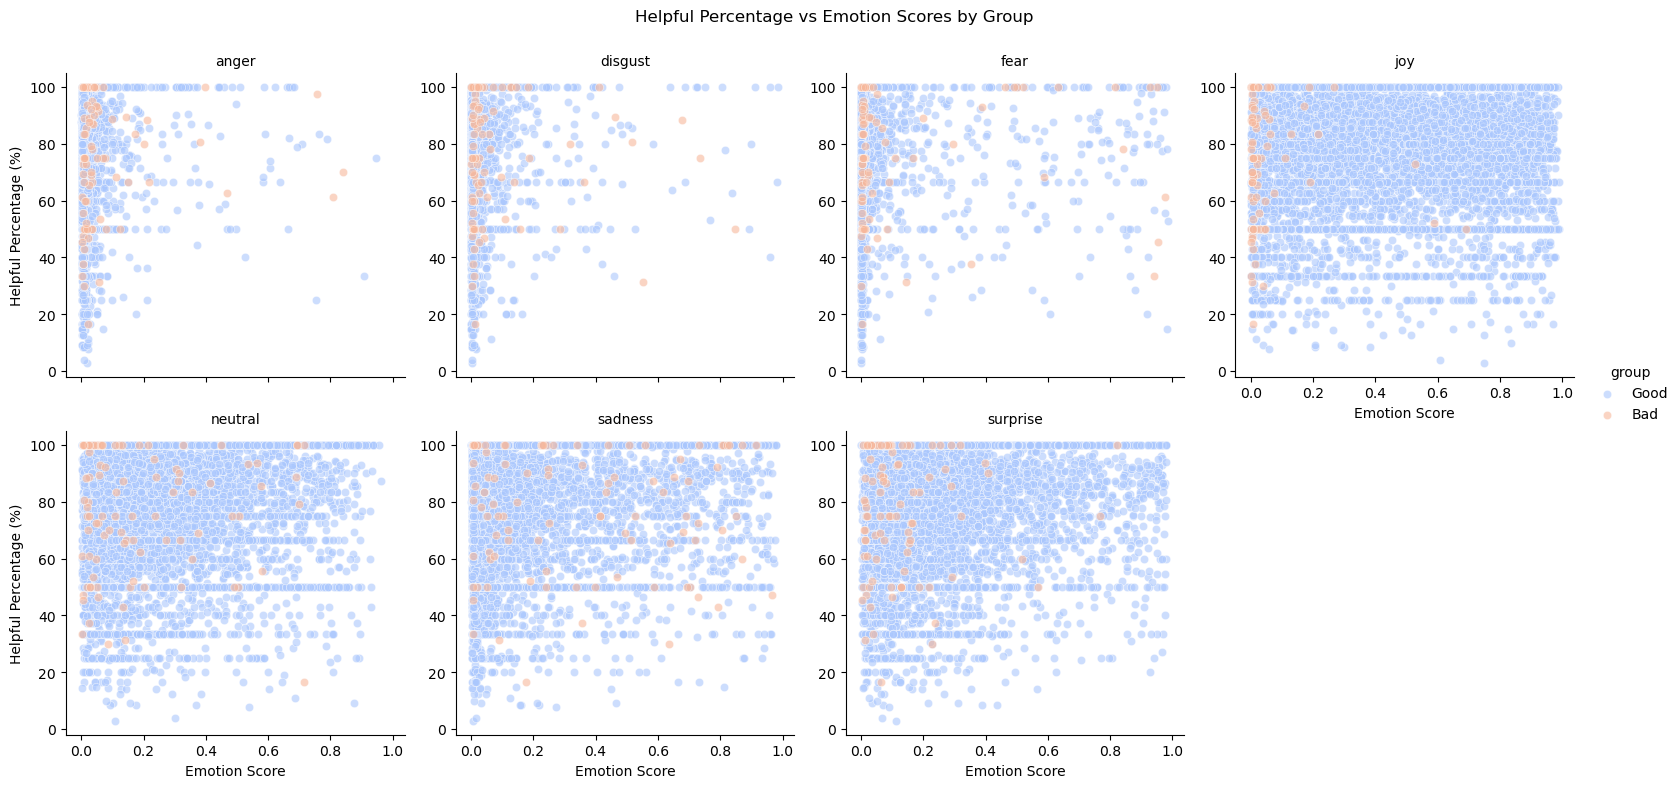

In [95]:
# Melt the DataFrame for easier plotting
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
melted = grouped.melt(id_vars=['group', 'helpful_percentage'], value_vars=emotion_columns, 
                 var_name='Emotion', value_name='emotion_score')

# Filter out rows with 0 values in Emotion Score or Helpful Percentage
melted_filtered = melted[(melted['emotion_score'] > 0) & (melted['helpful_percentage'] > 0)]

# Facet Grid
g = sns.FacetGrid(melted_filtered, col="Emotion", hue="group", sharey=False, col_wrap=4, height=4, palette='coolwarm')
g.map(sns.scatterplot, 'emotion_score', 'helpful_percentage', alpha=0.6)
g.add_legend()
g.set_titles("{col_name}")
g.set_axis_labels("Emotion Score", "Helpful Percentage (%)")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Helpful Percentage vs Emotion Scores by Group')
plt.show()

Above, we can see how joy, sadness, and suprise lead the scoring with the most widespread scores, colored by group. 

### Look into specific asin product: Phone headphones/earbuds mentioned in review

We can also look into specific subsets of the original dataframe. For example, reviews that include specific keywords. Below I will look into reviews that specifically mention 'headphones' or 'earbuds' in either the review or summary sections. I will store these products in pooled_buds_review_df and classify using a similar strategy as above. 

In [206]:
# Step 1: Filter reviews where both 'headphones' and 'earbuds' appear in 'reviewText' or 'summary'
case_asins  = df[
    (
        df['reviewText'].str.contains(r'\bheadphones\b', case=False, na=False) |  # "headphones" in reviewText
        df['reviewText'].str.contains(r'\bearbuds\b', case=False, na=False)    # "earbuds" in reviewText
    ) | 
    (
        df['summary'].str.contains(r'\bheadphones\b', case=False, na=False) |    # "headphones" in summary
        df['summary'].str.contains(r'\bearbuds\b', case=False, na=False)      # "earbuds" in summary
    )
]['asin'].unique() # Get unique asins


# Step 2: Filter the entire DataFrame for these asins
pooled_buds_reviews_df = df[df['asin'].isin(case_asins)]

# Display the filtered DataFrame
print(pooled_buds_reviews_df)

            reviewerID        asin         reviewerName helpful  \
480     A3872Y2XH0YDX1  B0000ALPBP      Amazon Customer  [0, 0]   
481     A1NGYBTJ5Y15Y7  B0000ALPBP           BoilerRage  [1, 1]   
482     A2WHVEFYI431UI  B0000ALPBP  C. Burke "CCrocker"  [0, 0]   
483     A3BEK0CFLRIBUY  B0000ALPBP               Daviel  [1, 1]   
484     A3STK5WDK5UB58  B0000ALPBP           D. Bratman  [0, 0]   
...                ...         ...                  ...     ...   
194324  A15TX8B2L8B20S  B00KTUWSSI         Jon Davidson  [0, 0]   
194325  A3JI7QRZO1QG8X  B00KTUWSSI    Joyce M. Davidson  [0, 0]   
194326  A1NHB2VC68YQNM  B00KTUWSSI       Nurse Farrugia  [0, 0]   
194327  A11LC938XF35XN  B00KTUWSSI   SJ Blouse "Stacey"  [0, 0]   
194328  A2I8KUDXTC9WYI  B00KTUWSSI              theresa  [0, 0]   

                                               reviewText  overall  \
480     Bought this for my wife to use with her Samsun...        4   
481     I love the compact design and fit of the ear r.

Now, I just have phone case reviews to look at, I will do the same sentiment analysis for each review in this truncated dataset: 

In [217]:
# Apply truncation
pooled_buds_reviews_df = pooled_buds_reviews_df.copy()
pooled_buds_reviews_df['truncated_review'] = pooled_buds_reviews_df['reviewText'].apply(truncate_review)

In [219]:
# Add sentiment scores to the grouped DataFrame
pooled_buds_reviews_df["sentiment_score"] = pooled_buds_reviews_df["truncated_review"].apply(classifier)

In [332]:
pooled_buds_reviews_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,total_votes,helpfulness_ratio,truncated_review,sentiment_score
0,A3872Y2XH0YDX1,B0000ALPBP,Amazon Customer,"[0, 0]",Bought this for my wife to use with her Samsun...,4,Wife loves it.,1302220800,"04 8, 2011",0,0,0.0,Bought this for my wife to use with her Samsun...,"[[{'label': 'anger', 'score': 0.00500664813444..."
1,A1NGYBTJ5Y15Y7,B0000ALPBP,BoilerRage,"[1, 1]",I love the compact design and fit of the ear r...,5,Love the design on this headset,1402099200,"06 7, 2014",1,1,1.0,I love the compact design and fit of the ear r...,"[[{'label': 'anger', 'score': 0.02914060652256..."
2,A2WHVEFYI431UI,B0000ALPBP,"C. Burke ""CCrocker""","[0, 0]",This serves the purpose if you need your hands...,3,It's okay - good price,1388275200,"12 29, 2013",0,0,0.0,This serves the purpose if you need your hands...,"[[{'label': 'anger', 'score': 0.00918262638151..."
3,A3BEK0CFLRIBUY,B0000ALPBP,Daviel,"[1, 1]",This has to be the cheapest headset I have eve...,5,Very good quality,1303862400,"04 27, 2011",1,1,1.0,This has to be the cheapest headset I have eve...,"[[{'label': 'anger', 'score': 0.00855293590575..."
4,A3STK5WDK5UB58,B0000ALPBP,D. Bratman,"[0, 0]","I don't know, I've always liked high-tech and ...",5,Better than bluetooth,1220745600,"09 7, 2008",0,0,0.0,"I don't know, I've always liked high-tech and ...","[[{'label': 'anger', 'score': 0.01280951686203..."


### Visualization

Below, I will unpack the sentiment_score into each individual emotion column into merged_df and add the overall 'good' 'bad' column to the dataset. 

In [251]:
emotion_scores_df = pd.DataFrame(
    pooled_buds_reviews_df['sentiment_score'].apply(
        lambda x: {score['label']: score['score'] for score in x[0]}  # Flatten the first element
    ).tolist()
)
pooled_buds_reviews_df.reset_index(drop=True, inplace=True)
emotion_scores_df.reset_index(drop=True, inplace=True)

In [255]:
merged_df = pd.concat([pooled_buds_reviews_df, emotion_scores_df], axis=1)

In [334]:
merged_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,...,truncated_review,sentiment_score,anger,disgust,fear,joy,neutral,sadness,surprise,group
0,A3872Y2XH0YDX1,B0000ALPBP,Amazon Customer,"[0, 0]",Bought this for my wife to use with her Samsun...,4,Wife loves it.,1302220800,"04 8, 2011",0,...,Bought this for my wife to use with her Samsun...,"[[{'label': 'anger', 'score': 0.00500664813444...",0.005007,0.003965,0.000918,0.011617,0.955779,0.005333,0.017382,Good
1,A1NGYBTJ5Y15Y7,B0000ALPBP,BoilerRage,"[1, 1]",I love the compact design and fit of the ear r...,5,Love the design on this headset,1402099200,"06 7, 2014",1,...,I love the compact design and fit of the ear r...,"[[{'label': 'anger', 'score': 0.02914060652256...",0.029141,0.028862,0.003035,0.321727,0.281716,0.011381,0.324138,Good
2,A2WHVEFYI431UI,B0000ALPBP,"C. Burke ""CCrocker""","[0, 0]",This serves the purpose if you need your hands...,3,It's okay - good price,1388275200,"12 29, 2013",0,...,This serves the purpose if you need your hands...,"[[{'label': 'anger', 'score': 0.00918262638151...",0.009183,0.005692,0.001901,0.086190,0.867984,0.007360,0.021691,Good
3,A3BEK0CFLRIBUY,B0000ALPBP,Daviel,"[1, 1]",This has to be the cheapest headset I have eve...,5,Very good quality,1303862400,"04 27, 2011",1,...,This has to be the cheapest headset I have eve...,"[[{'label': 'anger', 'score': 0.00855293590575...",0.008553,0.003926,0.001311,0.059835,0.846362,0.007376,0.072637,Good
4,A3STK5WDK5UB58,B0000ALPBP,D. Bratman,"[0, 0]","I don't know, I've always liked high-tech and ...",5,Better than bluetooth,1220745600,"09 7, 2008",0,...,"I don't know, I've always liked high-tech and ...","[[{'label': 'anger', 'score': 0.01280951686203...",0.012810,0.018030,0.001974,0.009966,0.928196,0.010809,0.018216,Good


In [261]:
# Separtate into good and bad reviews below
merged_df['group'] = merged_df['overall'].apply(lambda x: 'Good' if x > 2.5 else 'Bad')

In [382]:
emotion_means = merged_df.groupby('group')[emotion_columns].mean()
emotion_means

,anger,disgust,fear,joy,neutral,sadness,surprise
group,,,,,,,
Bad,0.062227,0.126475,0.043458,0.033679,0.350920,0.232459,0.150782
Good,0.019960,0.029045,0.020902,0.252690,0.491595,0.057922,0.127887


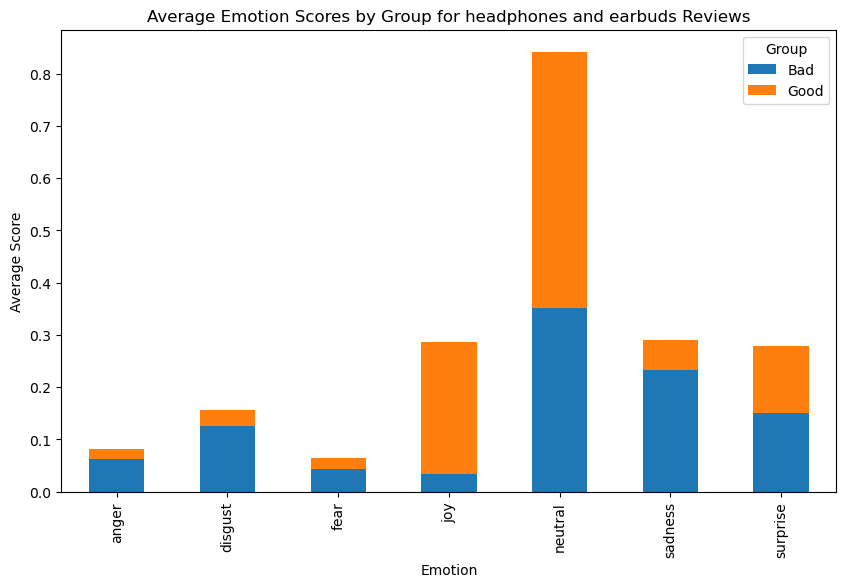

In [337]:
# List of emotion columns
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# Stacked Bar Chart
emotion_means = merged_df.groupby('group')[emotion_columns].mean()
emotion_means.T.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Average Emotion Scores by Group for headphones and earbuds Reviews')
plt.ylabel('Average Score')
plt.xlabel('Emotion')
plt.legend(title='Group')
plt.show()

In [265]:
merged_df['group'].value_counts()

group
Good    45446
Bad      5817
Name: count, dtype: int64

As we can see above, good reviews for headphones/earbuds are dominated by neutral sentiment scores followed by joy. For bad reviews, neutral, disgust, adn suprise lead the way. Interestingly again, suprise seems to be failry equal for both good and bad reviews. 

In [267]:
grouped_cases['asin'].value_counts()

asin
B005SUHPO6    837
B009RXU59C    636
B007FHX9OK    557
B0073FCPSK    526
B008DJIIG8    510
             ... 
B002MUUNEE      5
B004E7EKV0      5
B008R782IA      5
B00GYA3Q9C      5
B00DYE8B3W      5
Name: count, Length: 1330, dtype: int64

We can also look into specific asins for headphones/earbuds reviews like the B008DJIIG8 product with 510 value counts: 

In [388]:
product = merged_df[merged_df['asin'] == 'B008DJIIG8']
product.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,...,truncated_review,sentiment_score,anger,disgust,fear,joy,neutral,sadness,surprise,group
26096,A2EMG7NII6RF2F,B008DJIIG8,"88@48 ""applemac""","[0, 0]",Like this case to give the Note II an 'undress...,5,Very glossy!,1387411200,"12 19, 2013",0,...,Like this case to give the Note II an 'undress...,"[[{'label': 'anger', 'score': 0.00896920822560...",0.008969,0.066543,0.008439,0.013524,0.845747,0.034224,0.022554,Good
26097,A59HU91GDMDP1,B008DJIIG8,Aaron,"[0, 0]",It is OK but a little blah looking. Seems lik...,3,basic case,1376697600,"08 17, 2013",0,...,It is OK but a little blah looking. Seems lik...,"[[{'label': 'anger', 'score': 0.00196382193826...",0.001964,0.007021,0.005739,0.019514,0.127438,0.801126,0.037199,Good
26098,A1M1JD1N802S0D,B008DJIIG8,aaron,"[0, 0]",This case is what I was looking for;Fits goodN...,4,Nice and simple,1357430400,"01 6, 2013",0,...,This case is what I was looking for;Fits goodN...,"[[{'label': 'anger', 'score': 0.01364919077605...",0.013649,0.003381,0.002645,0.588891,0.273819,0.014277,0.103338,Good
26099,A64WSFVVAUK58,B008DJIIG8,"Aaron Mills ""VWHSRocket""","[0, 0]",Purchased this case for my wife who just got a...,5,Great AT&T S3 Case,1366675200,"04 23, 2013",0,...,Purchased this case for my wife who just got a...,"[[{'label': 'anger', 'score': 0.00774148199707...",0.007741,0.048367,0.008410,0.037834,0.870770,0.014299,0.012578,Good
26100,A1G5VR6YBZT1DG,B008DJIIG8,Abby,"[0, 0]","Very cute pink color, lighter than the picture...",5,Love it!,1347321600,"09 11, 2012",0,...,"Very cute pink color, lighter than the picture...","[[{'label': 'anger', 'score': 0.01367289852350...",0.013673,0.037576,0.002317,0.015308,0.897742,0.015858,0.017526,Good


#### Look into Asin B005SUHPO6

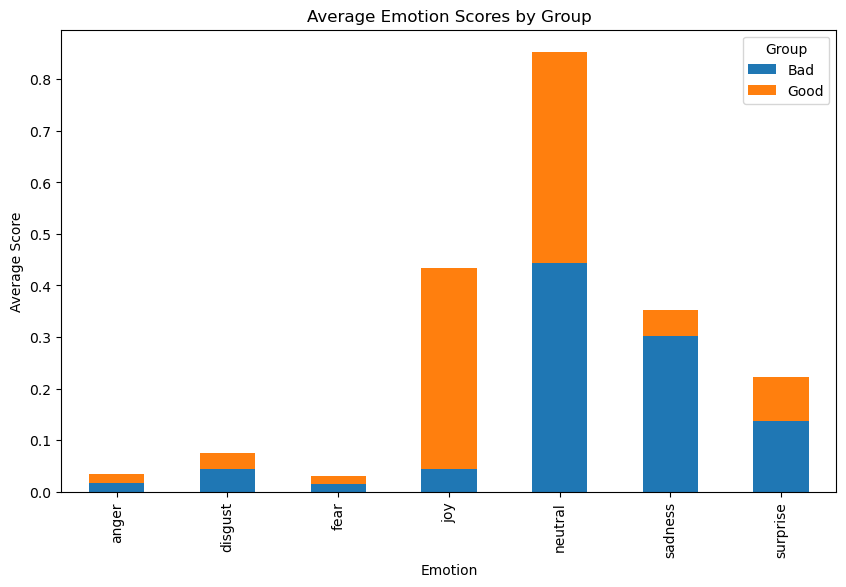

In [390]:
# Stacked Bar Chart
emotion_means = product.groupby('group')[emotion_columns].mean()
emotion_means.T.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Average Emotion Scores by Group')
plt.ylabel('Average Score')
plt.xlabel('Emotion')
plt.legend(title='Group')
plt.show()

In [295]:
product['group'].value_counts()

group
Good    481
Bad      29
Name: count, dtype: int64

#### Look into bad rating ratio for asins

In [300]:
# Group by `asin` and calculate counts
rating_counts = merged_df.groupby('asin').agg(
    total_ratings=('group', 'count'),
    bad_ratings=('group', lambda x: (x == 'Bad').sum())
)

# Add the ratio column
rating_counts['bad_rating_ratio'] = rating_counts['bad_ratings'] / rating_counts['total_ratings']

# Reset index if needed
rating_counts.reset_index(inplace=True)

rating_counts

,asin,total_ratings,bad_ratings,bad_rating_ratio
0,B0000ALPBP,30,10,0.333333
1,B0001YX9ZI,6,0,0.000000
2,B000246XQE,10,2,0.200000
3,B0002SYC5O,17,1,0.058824
4,B00069IQG0,21,4,0.190476
...,...,...,...,...
1325,B00KBZ414K,5,0,0.000000
1326,B00KD4748Y,8,0,0.000000
1327,B00KHV6TIE,47,0,0.000000
1328,B00KJLMBQQ,28,2,0.071429


In [310]:
bad_ratings_df = rating_counts[rating_counts['bad_rating_ratio'] > 0.5]
bad_ratings_df

,asin,total_ratings,bad_ratings,bad_rating_ratio
71,B0016I6GUS,5,3,0.600000
103,B001KYJ80I,5,4,0.800000
119,B001W6Q64U,6,4,0.666667
138,B002G9GRFA,5,3,0.600000
298,B004E7EKV0,5,3,0.600000
539,B006VDPDHU,15,9,0.600000
613,B007YYUUA0,24,14,0.583333
729,B00904UE3A,5,3,0.600000
870,B00A6YEUXI,13,8,0.615385
937,B00B7Q7D4M,11,6,0.545455


All of these products were said to be majority bad by consumers, Let's visualize these bad rated 'headphone'/'earbud' reviews

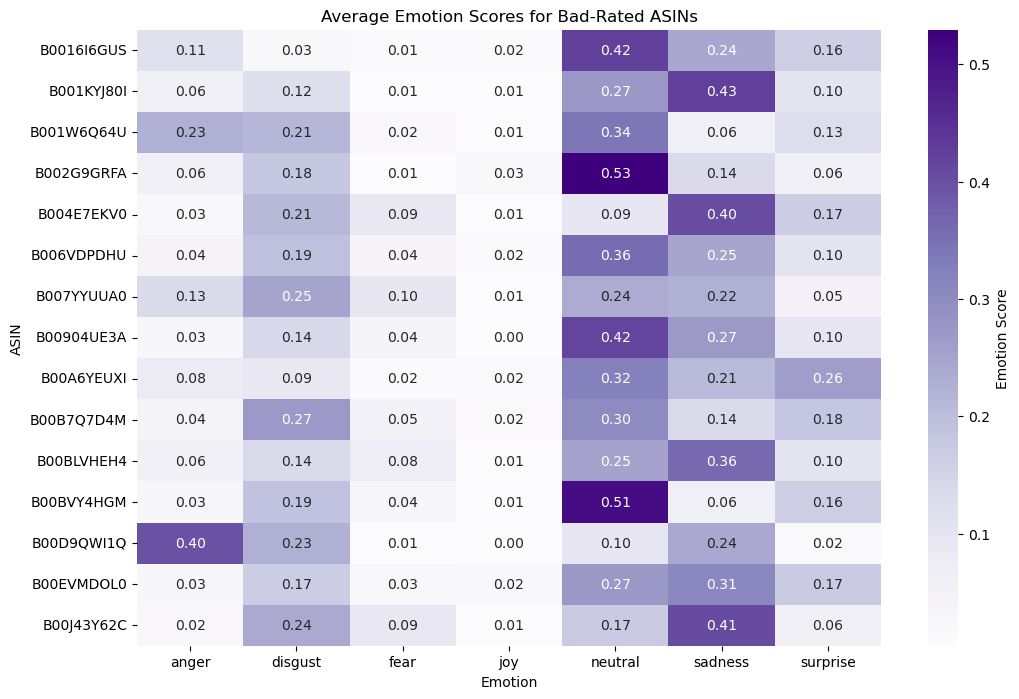

C:\Users\heley\AppData\Local\Temp\ipykernel_28968\4064381770.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Emotion', y='Score', data=melted_data, palette='Set2')


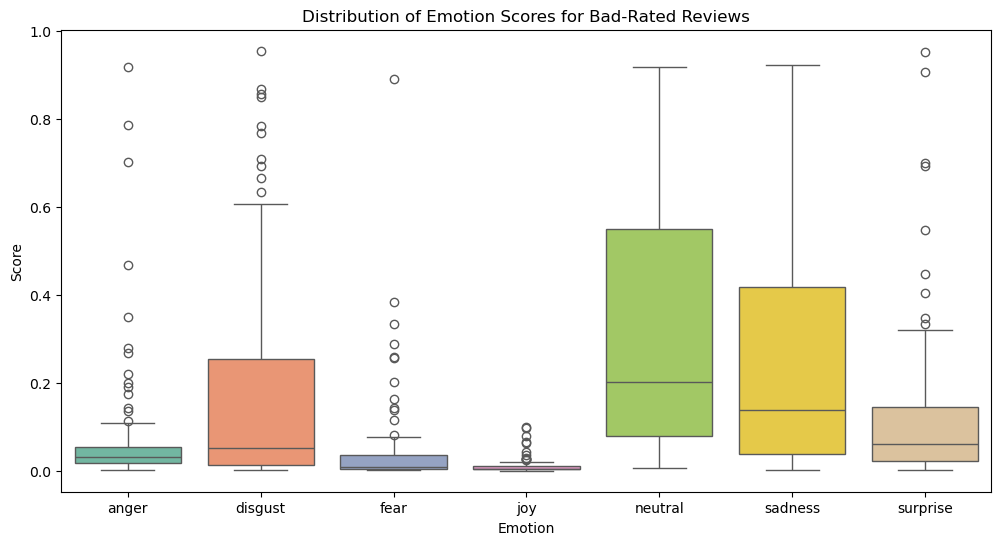

In [314]:
# Filter bad-rated asins
bad_asins = bad_ratings_df['asin'].unique()
bad_rated_reviews = merged_df[
    (merged_df['asin'].isin(bad_asins)) & (merged_df['group'] == 'Bad')
]

# Select emotion columns
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
emotion_data = bad_rated_reviews[['asin'] + emotion_columns]

# Aggregate emotion scores by `asin`
emotion_means = emotion_data.groupby('asin').mean().reset_index()

# Visualization: Heatmap of average emotion scores
plt.figure(figsize=(12, 8))
sns.heatmap(
    emotion_means.set_index('asin'),
    annot=True,
    cmap='Purples',
    fmt='.2f',
    cbar_kws={'label': 'Emotion Score'}
)
plt.title('Average Emotion Scores for Bad-Rated ASINs')
plt.ylabel('ASIN')
plt.xlabel('Emotion')
plt.show()

# Optional: Boxplot to show distribution of emotion scores
plt.figure(figsize=(12, 6))
melted_data = bad_rated_reviews.melt(id_vars=['asin'], value_vars=emotion_columns, 
                                     var_name='Emotion', value_name='Score')
sns.boxplot(x='Emotion', y='Score', data=melted_data, palette='Set2')
plt.title('Distribution of Emotion Scores for Bad-Rated Reviews')
plt.show()


Above, we can now see each individual asin annd why they were rated poorly on emotional scale. For example, B00D9QWI1Q had anger as it's leading emotion. We can also see a boxplot above with the overall emotional scores for these very poor products above. 

### Summary

Overall, many different kinds of summarizations can be made for this data and sentiment analysis. Above, we categorized by 'asin' and specifically reviews that use 'headphones' and 'earbuds'. Specifically looking at the bad reviews and why they were getting these reviews. Additionally, the 'helpful' variable was looked into along with how each emotion affects each other using heatmaps. Various graphical techniques and data minipulation where looked into to help better understand the data.